## Impor Library yang Diperlukan

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.10.0


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Dense, Dropout, GlobalAveragePooling2D, MaxPooling2D, Flatten,
    Conv2D, BatchNormalization, Activation, Input,Reshape, Multiply
)
from tensorflow.keras.regularizers import l2


## Mengambil Menyiapkan dataset

In [ ]:
#tes speed internet
# !apt-get install speedtest-cli
# !speedtest-cli


In [ ]:
# !gdown --id 1rfGURIRAHEvRxNgX3l1uio9Vxym2y-gC



file original dataset fer2013 https://drive.google.com/file/d/1rfGURIRAHEvRxNgX3l1uio9Vxym2y-gC/view?usp=sharing


file modifikasi dataset fer2013 https://drive.google.com/file/d/1Tb6gH8dXGBZ6hoIfCMN01J4p6r0hDln0/view?usp=sharing

In [ ]:
# !gdown --id 1Tb6gH8dXGBZ6hoIfCMN01J4p6r0hDln0



## custom kalau dilaptop local

In [ ]:
# !pip install tensorflow==2.10.0


In [ ]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpu_devices))

Num GPUs Available:  1


### Load dataset

In [ ]:
# !unzip /content/face_populer.zip

In [ ]:
# !unzip /content/dataset_4face.zip

In [ ]:
dataset_test = './dataset_4face/test'
dataset_train = './dataset_4face/train'

## Mengecek Keseimbangan Kelas

Jumlah gambar per kategori di folder train:
angry: 3995
happy: 7215
neutral: 4965
sad: 4830

Jumlah gambar per kategori di folder test:
angry: 958
happy: 1774
neutral: 1233
sad: 1247


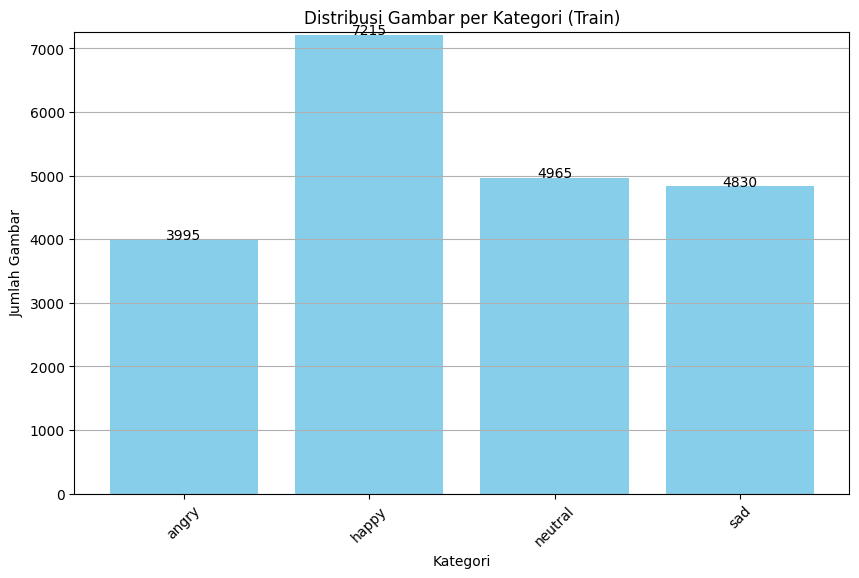

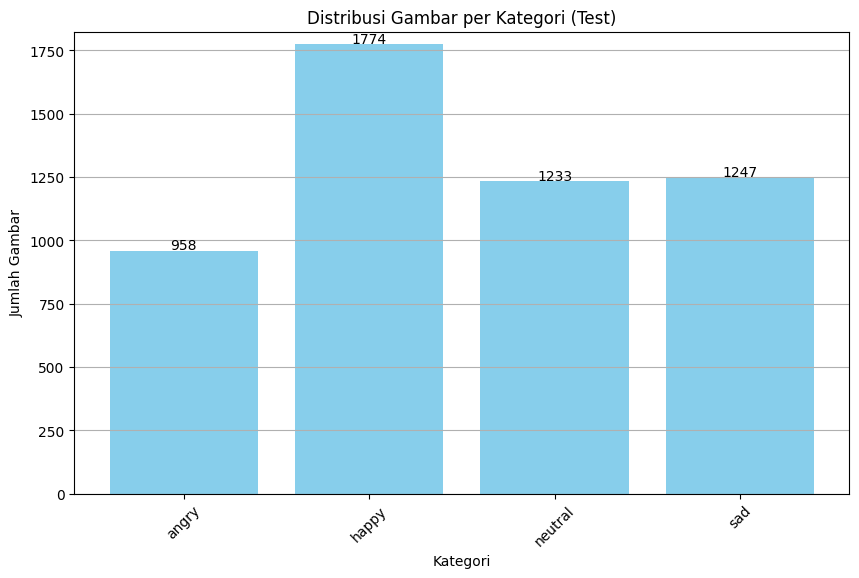

In [ ]:
def count_images_in_directory(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            count = len(os.listdir(class_path))
            class_counts[class_name] = count
    return class_counts


train_counts = count_images_in_directory(dataset_train )
test_counts = count_images_in_directory(dataset_test)


print("Jumlah gambar per kategori di folder train:")
for class_name, count in train_counts.items():
    print(f"{class_name}: {count}")

print("\nJumlah gambar per kategori di folder test:")
for class_name, count in test_counts.items():
    print(f"{class_name}: {count}")

def plot_class_distribution(class_counts, title):
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts, color='skyblue')
    plt.xlabel('Kategori')
    plt.ylabel('Jumlah Gambar')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.ylim(0, max(counts) + 50)  # Tambah sedikit ruang di atas grafik
    plt.grid(axis='y')

    for i, count in enumerate(counts):
        plt.text(i, count + 5, str(count), ha='center')

    plt.show()


plot_class_distribution(train_counts, "Distribusi Gambar per Kategori (Train)")
plot_class_distribution(test_counts, "Distribusi Gambar per Kategori (Test)")

In [ ]:
dataset_test = './dataset_4face/test'
dataset_train = './dataset_4face/train'

image_size = (48, 48)
batch_size = 64


train_datagen = ImageDataGenerator(
    rescale=1 / 255.0,
    rotation_range = 10,
    zoom_range = 0.1,
    horizontal_flip = True
)

train_generator = train_datagen.flow_from_directory(
    directory=dataset_train,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=True,
    seed=42

)

test_datagen = ImageDataGenerator(
    rescale=1 / 255.0,
)

validation_generator = test_datagen.flow_from_directory(
    directory=dataset_test,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode = 'grayscale',
    shuffle=True,
    seed=42


)


labels = train_generator.class_indices
print(labels)


total_train_images = train_generator.samples
total_val_images = validation_generator.samples
total_images = total_train_images + total_val_images

print("Total training images:", total_train_images)
print("Total validation images:", total_val_images)
print("Total images in dataset:", total_images)

Found 21005 images belonging to 4 classes.
Found 5212 images belonging to 4 classes.
{'angry': 0, 'happy': 1, 'neutral': 2, 'sad': 3}
Total training images: 21005
Total validation images: 5212
Total images in dataset: 26217


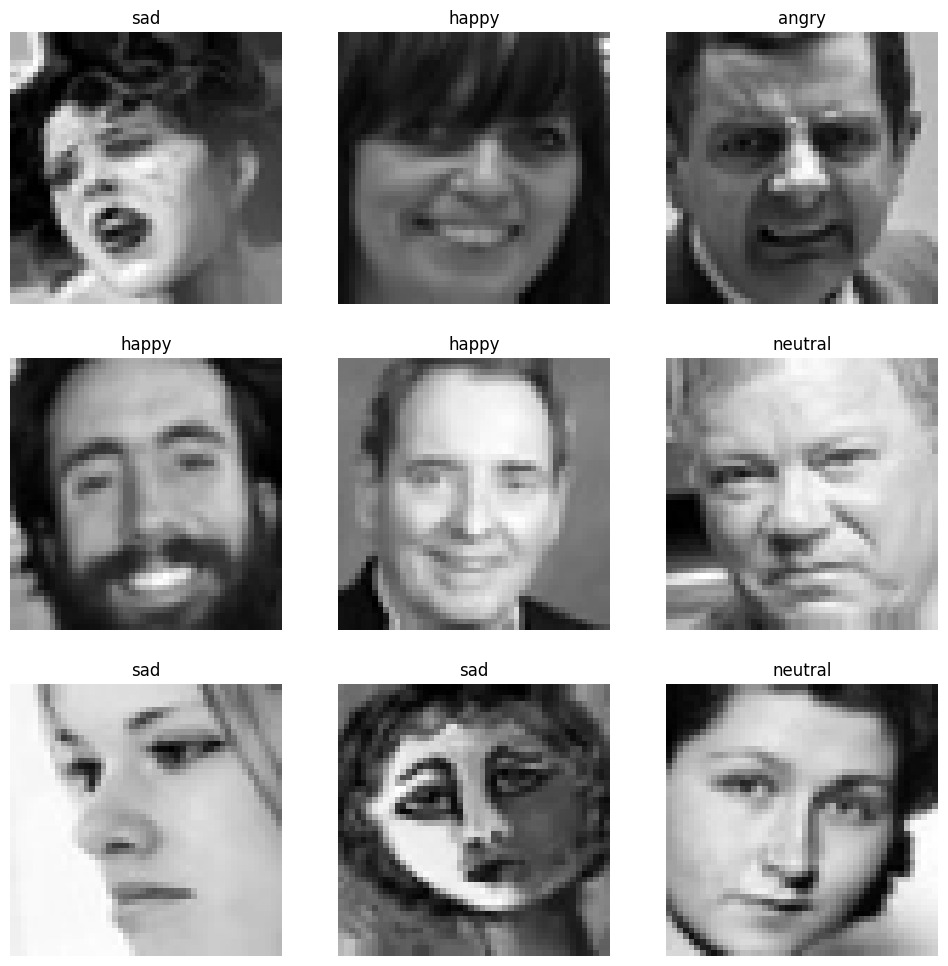

In [ ]:
images, labels = train_generator.next()

num_images = 9

plt.figure(figsize=(12, 12))

class_indices = train_generator.class_indices
class_labels = list(class_indices.keys())

for i in range(num_images):

    ax = plt.subplot(3, 3, i + 1)


    image = images[i]
    image = np.clip(image, 0, 1)

    plt.imshow(image.squeeze(), cmap='gray')

    label_index = np.argmax(labels[i])
    label_name = class_labels[label_index]

    plt.title(label_name)
    plt.axis("off")

plt.show()


In [ ]:
def se_block(input_tensor, ratio=8):
    channel_axis = -1
    filters = input_tensor.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(input_tensor)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)

    x = Multiply()([input_tensor, se])
    return x


def create_model(input_shape = (48,48,1),num_classes=4):

    input = Input(shape=input_shape)

    x = Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(input)
    x = BatchNormalization()(x)
    x = se_block(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = se_block(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.4)(x)

    x = Conv2D(filters=256, kernel_size=3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = se_block(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.4)(x)

    x = Conv2D(filters=512, kernel_size=3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = se_block(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.4)(x)

    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(num_classes, activation='softmax')(x)
    return Model(inputs=input, outputs=x)

if __name__=='__main__':
    model = create_model()
    model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 conv2d_2 (Conv2D)              (None, 48, 48, 64)   640         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_2 (BatchNo  (None, 48, 48, 64)  256         ['conv2d_2[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 global_average_pooling2d_2 (Gl  (None, 64)          0           ['batch_normalization_2[0][0]

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model_checkpoint = ModelCheckpoint(
    'best_models.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)


Epoch 1/30
329/329 [==============================] - 277s 779ms/step - loss: 1.6667 - accuracy: 0.3374 - val_loss: 1.7638 - val_accuracy: 0.3406 - lr: 0.0010
Epoch 2/30
329/329 [==============================] - 40s 120ms/step - loss: 1.3290 - accuracy: 0.4306 - val_loss: 1.2107 - val_accuracy: 0.4474 - lr: 0.0010
Epoch 3/30
329/329 [==============================] - 40s 122ms/step - loss: 1.1758 - accuracy: 0.4966 - val_loss: 1.0650 - val_accuracy: 0.5361 - lr: 0.0010
Epoch 4/30
329/329 [==============================] - 39s 119ms/step - loss: 1.0818 - accuracy: 0.5363 - val_loss: 1.1824 - val_accuracy: 0.4994 - lr: 0.0010
Epoch 5/30
329/329 [==============================] - 43s 130ms/step - loss: 1.0150 - accuracy: 0.5698 - val_loss: 0.9334 - val_accuracy: 0.6071 - lr: 0.0010
Epoch 6/30
329/329 [==============================] - 40s 120ms/step - loss: 0.9755 - accuracy: 0.5836 - val_loss: 0.9159 - val_accuracy: 0.6145 - lr: 0.0010
Epoch 7/30
329/329 [==============================]

In [ ]:
test_loss, test_accuracy = model.evaluate(validation_generator)
print(f'Test accuracy: {test_accuracy:.2f}')

82/82 [==============================] - 7s 80ms/step - loss: 0.7070 - accuracy: 0.7180
Test accuracy: 0.72


In [ ]:
model.save('modelV2.h5')

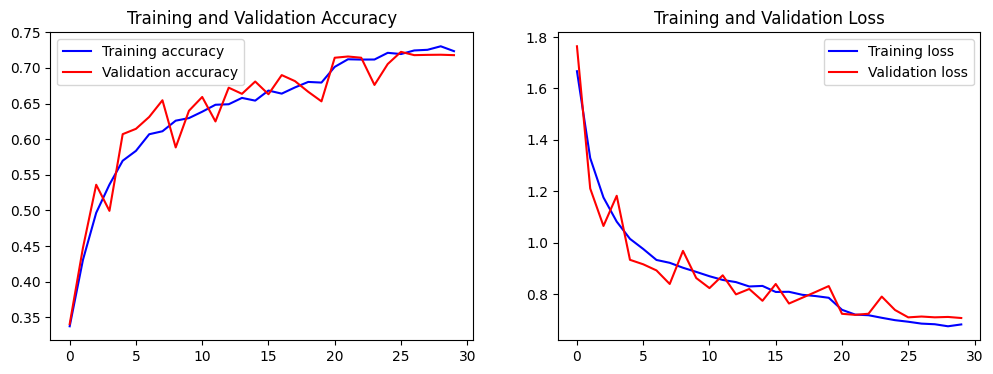

In [ ]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()


plot_training_history(history)

Note belajar Grad Cam

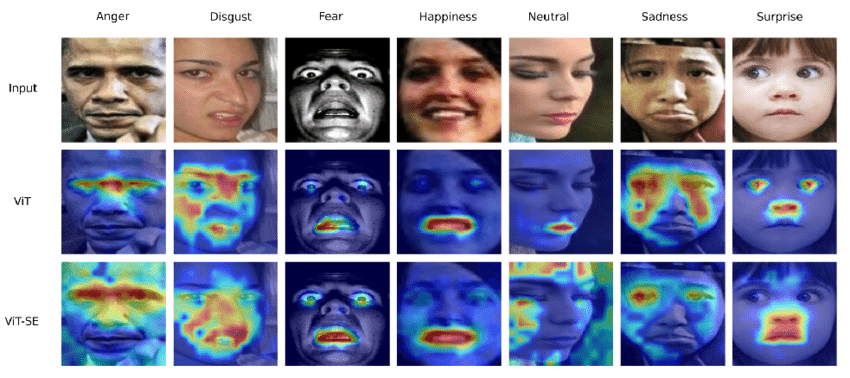

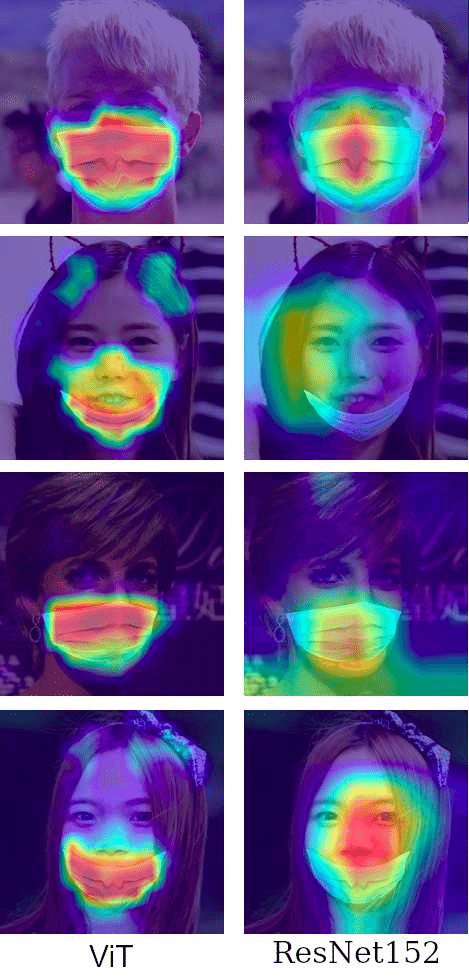